# Getting Started with CellRank

## Preliminaries

### Import packages & data

In [1]:
import cellrank as cr
import scanpy as sc

sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

In [2]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)

To demonstrate the appproach in this tutorial, we will use a scRNA-seq dataset of human bone marrow, which can be conveniently acessed through ``cellrank.datasets.bone_marrow`` from Setty et al. 2019. 

In [3]:
adata = cr.datasets.bone_marrow()
adata

100%|██████████| 370M/370M [02:18<00:00, 2.80MB/s] 


AnnData object with n_obs × n_vars = 5780 × 27876
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    var: 'palantir'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs'
    layers: 'spliced', 'unspliced'

Move [MAGIC](https://github.com/KrishnaswamyLab/MAGIC) imputed data to ``~anndata.AnnData.layers``.  

In [4]:
adata = adata[:, adata.var["palantir"]].copy()
adata.layers["MAGIC_imputed_data"] = adata.obsm["MAGIC_imputed_data"].copy()

### Preprocess the data

Filter and normalize. 

In [5]:
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Compute PCA and k-nearest neighbor (k-NN) graph. 

In [6]:
sc.tl.pca(adata, random_state=0)
sc.pp.neighbors(adata, random_state=0)

Visualize this data, using the t-SNE embedding, cluster labels and [Palantir](https://github.com/dpeerlab/Palantir) pseudotime provided with the original study Setty et al., 2019.  

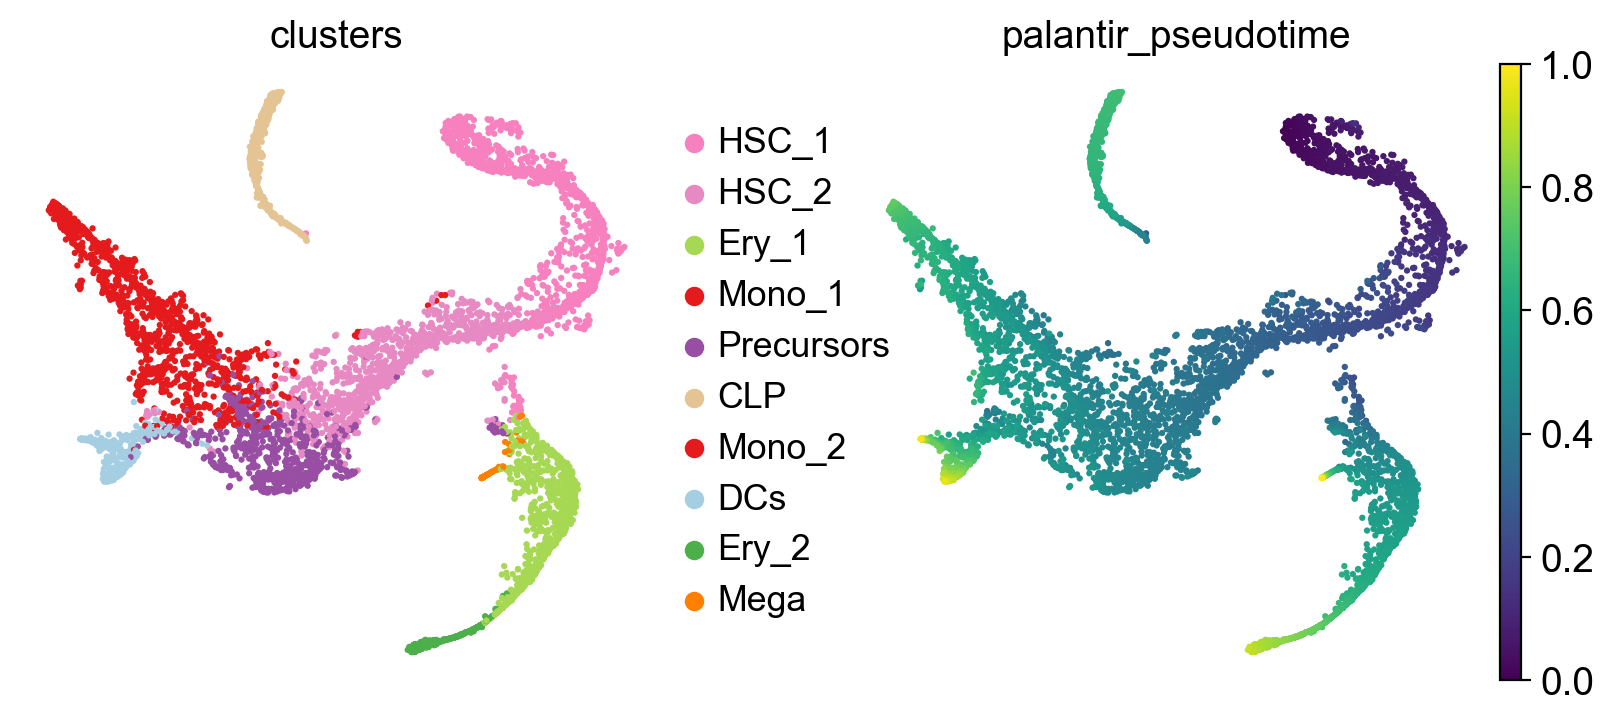

In [7]:
sc.pl.embedding(adata, basis="tsne", color=["clusters", "palantir_pseudotime"])

## Working with kernels

### Set up a kernel

To construct a transition matrix, CellRank offers a number of kernel classes in ``cellrank.kernels``. To demonstrate the concept, we'll use the ``cellrank.kernels.PseudotimeKernel` which biases k-NN graph edges to point into the direction of increasing pseudotime, inspired by [Palantir](https://github.com/dpeerlab/Palantir) Setty et al., 2019. 

For a full list of kernels, check out our `API <cellrank.kernels>`. To initialize a kernel object, simply run the following:

In [8]:
from cellrank.kernels import PseudotimeKernel

pk = PseudotimeKernel(adata, time_key="palantir_pseudotime")

Note that kernels need an `anndata.AnnData` object to read data from it - CellRank is part of the [Scanpy/AnnData ecosystem](https://scanpy.readthedocs.io/en/latest/). The only exception to this is the `cellrank.kernels.PrecomputedKernel` which directly accepts a transition matrix, thus making it possible to interface to CellRank from outside the scanpy/AnnData world. 

To learn more about our kernel object, we can print it. 

In [9]:
pk

PseudotimeKernel[n=5780]

There isn't very much here yet! Let's use this kernel to compute a cell-cell `cellrank.kernels.PseudotimeKernel.transition_matrix`. 

In [11]:
pk.compute_transition_matrix()

Computing transition matrix based on pseudotime
    Finish (0:00:00)


PseudotimeKernel[n=5780, dnorm=False, scheme='hard', frac_to_keep=0.3]

If we print the kernel again, we can inspect the parameters that were used to compute this transition matrix. 

In [12]:
pk

PseudotimeKernel[n=5780, dnorm=False, scheme='hard', frac_to_keep=0.3]

To get a first impression of the cellular dynamics in this dataset, we can simulate {meth}`random walks <cellrank.kernels.PseudotimeKernel.plot_random_walks>` on the [Markov chain](https://en.wikipedia.org/wiki/Markov_chain) implied by the transition matrix, starting from hematopoietic stem cells (HSCs), and visualize these in the t-SNE embedding. 

Simulating `100` random walks of maximum length `1445`


100%|██████████| 100/100 [00:19<00:00,  5.04sim/s]


    Finish (0:00:19)
Plotting random walks


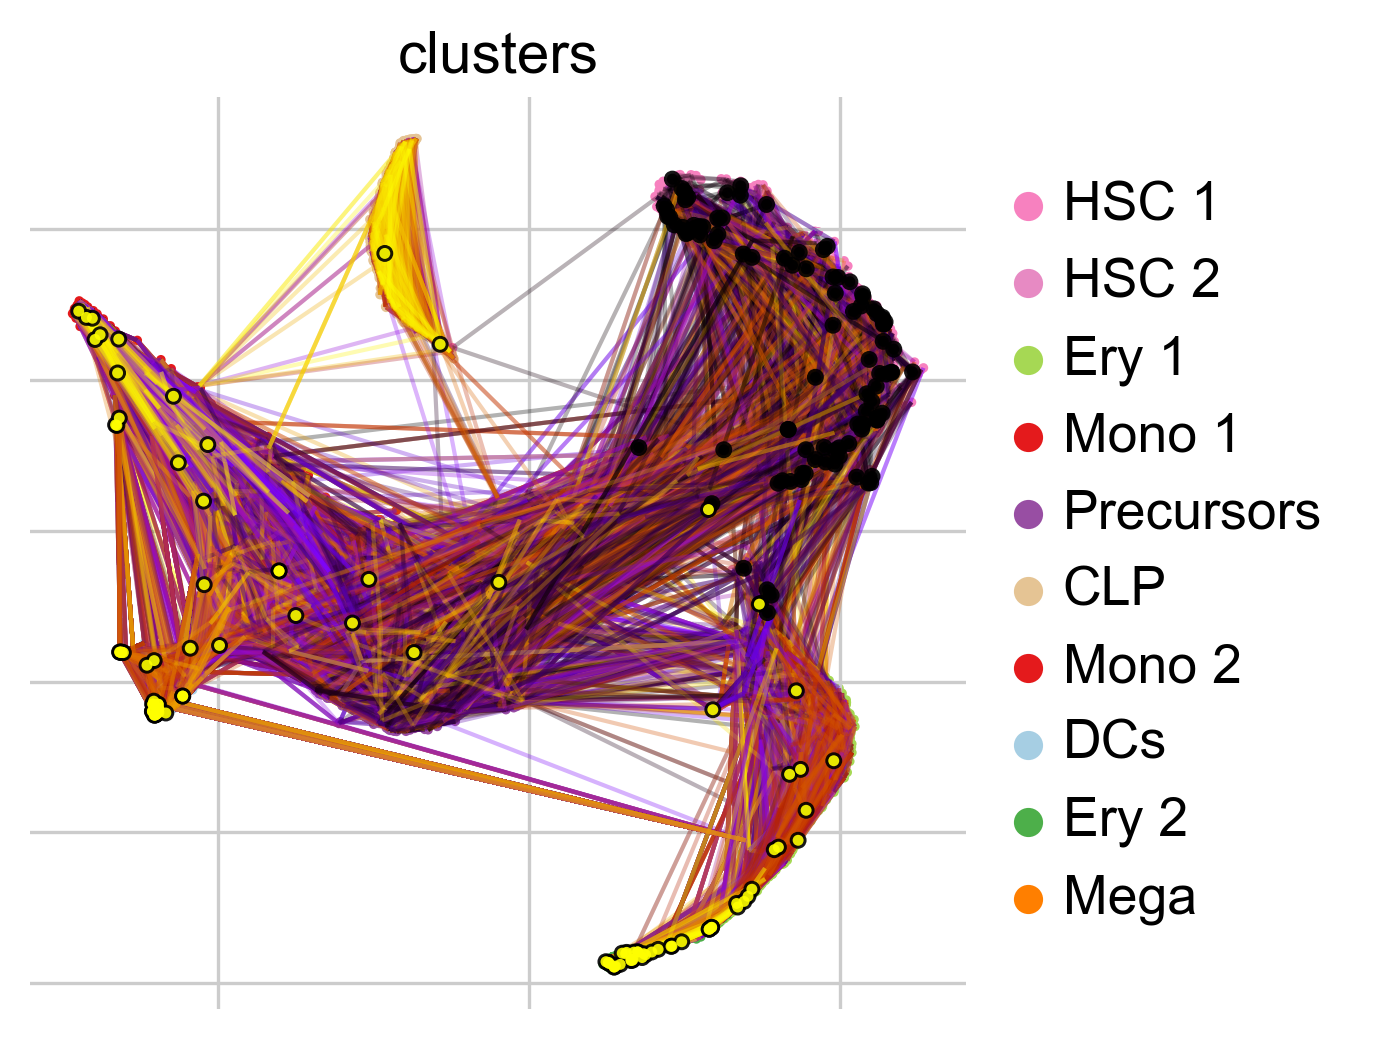

In [13]:
pk.plot_random_walks(
    seed=0,
    n_sims=100,
    start_ixs={"clusters": "HSC_1"},
    basis="tsne",
    legend_loc="right",
    dpi=150,
)

Black and yellow dots indicate random walk start and terminal cells, respectively. Overall, this reflects the known differentiation hierachy in human hematopoiesis. 

### Combining different kernels

Any two kernels can be globally combined via a weighted mean. To demonstrate this, let's set up an additional `cellrank.kernels.ConnectivityKernel`, based on gene expression similarity. 

In [14]:
from cellrank.kernels import ConnectivityKernel

ck = ConnectivityKernel(adata).compute_transition_matrix()

Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


Print the kernel to see some properties

In [15]:
ck

ConnectivityKernel[n=5780, dnorm=True, key='connectivities']

Combine with the `cellrank.kernels.PseudotimeKernel` PseudotimeKernel from above. 

In [16]:
combined_kernel = 0.8 * pk + 0.2 * ck
combined_kernel

(0.8 * PseudotimeKernel[n=5780, dnorm=False, scheme='hard', frac_to_keep=0.3] + 0.2 * ConnectivityKernel[n=5780, dnorm=True, key='connectivities'])

This works for any combination of kernels, and generalizes to more than two kernels. Kernel combinations allow you to use distinct sources of information to describe cellular dynamics. 

### Writing and reading a kernel

Sometimes, we might want to write the kernel to disk, to either continue with the analysis later on, or to pass it to someone else. This can be easily done; simply write the kernel to adata, and write adata to file: 

In [17]:
pk.write_to_adata()
adata.write("hematopoiesis.h5ad")

To continue with the analysis, we read the {class}`anndata.AnnData` object from disk, and initialize a new kernel from the AnnData object. 

In [18]:
adata = sc.read("hematopoiesis.h5ad")
pk_new = cr.kernels.PseudotimeKernel.from_adata(adata, key="T_fwd")
pk_new

PseudotimeKernel[n=5780, dnorm=False, frac_to_keep=0.3, scheme='hard']

## Working with estimators

### Set up an estimator

Estimators take a `kernel` object and offer methods to analyze it. The main objective is to decompose the state space into a set of macrostates that represent the slow-time scale dynamics of the process. A subset of these macrostates will be the initial or terminal states of the process, the remaining states will be intermediate transient states. CellRank currently offers two estimator classes in `cellrank.estimators`:

 - `cellrank.estimators.CFLARE`: **C**lustering and **F**iltering **L**eft **A**nd **R**ight **E**igenvectors. Heuristic method based on the spectrum of the transition matrix.
 - `cellrank.estimators.GPCCA`: **G**eneralized **P**erron **C**luster **C**luster **A**nalysis: project the Markov chain onto a small set of macrostates using a Galerkin projection which maximizes the self-transition probability for the macrostates, {cite}`reuter:18, reuter:19`. 
 

In [22]:
from cellrank.estimators import GPCCA

g = GPCCA(pk_new)
print(g)

GPCCA[kernel=PseudotimeKernel[n=5780], initial_states=None, terminal_states=None]


### Identify initial & terminal states

Fit the estimator to compute macrostates of cellular dynamics; these may include `initial <cellrank.estimators.GPCCA.initial_states>`, `terminal <cellrank.estimators.GPCCA.terminal_states>` and intermediate states. 

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:05:07)
Computing `10` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:50)


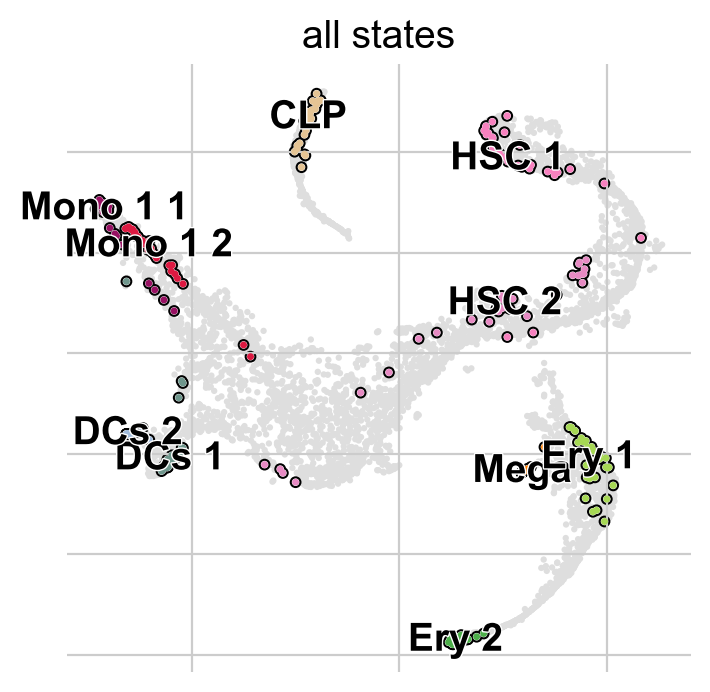

In [23]:
g.fit(n_states=10, cluster_key="clusters")
g.plot_macrostates(which="all")

For each macrostate, the algorithm computes an associated stability value. Let's use the most stable macrostates as `terminal <cellrank.estimators.GPCCA.terminal_states>`. 

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


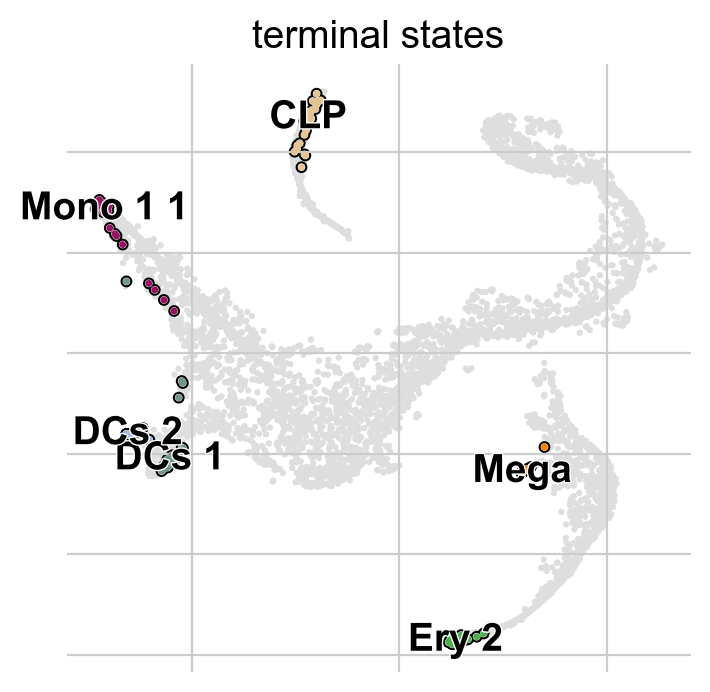

In [24]:
g.predict_terminal_states(method="top_n", n_states=6)
g.plot_macrostates(which="terminal")

This correctly identified all major `terminal states <cellrank.estimators.GPCCA.terminal_states>` in this dataset. CellRank can also identify `initial states <cellrank.estimators.GPCCA.initial_states>` - in this dataset, that does not make too much sense though, as the initial state was manually passed to Palantir to root the pseudotime computation. 

### Compute fate probabilities and driver genes

We can now compute how likely each cell is to reach each terminal state using {func}`~cellrank.estimators.GPCCA.compute_fate_probabilities`. 

Computing fate probabilities
Defaulting to `'gmres'` solver.


100%|██████████| 6/6 [00:00<00:00, 23.35/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


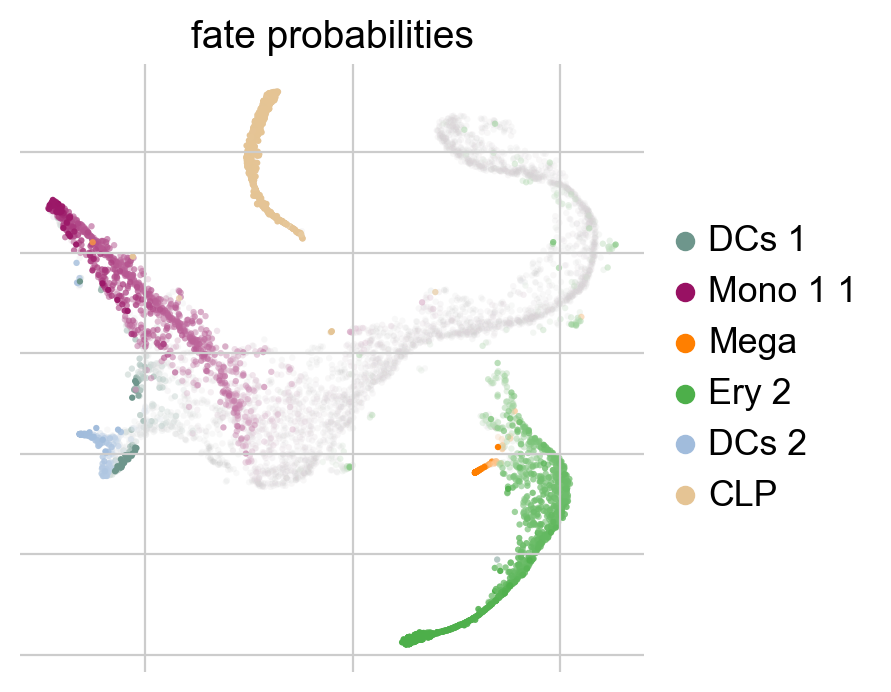

In [25]:
g.compute_fate_probabilities()
g.plot_fate_probabilities(legend_loc="right")

The plot above combines fate probabilities towards all terminal states, each cell is colored according to its most likely fate; color intensity reflects the degree of lineage priming. We could equally plot fate probabilities separately for each terminal state, or we can visualize them jointly in a {func}`circular projection <cellrank.pl.circular_projection>` {cite}`velten:17, lange:22`. 

Solving TSP for `6` states


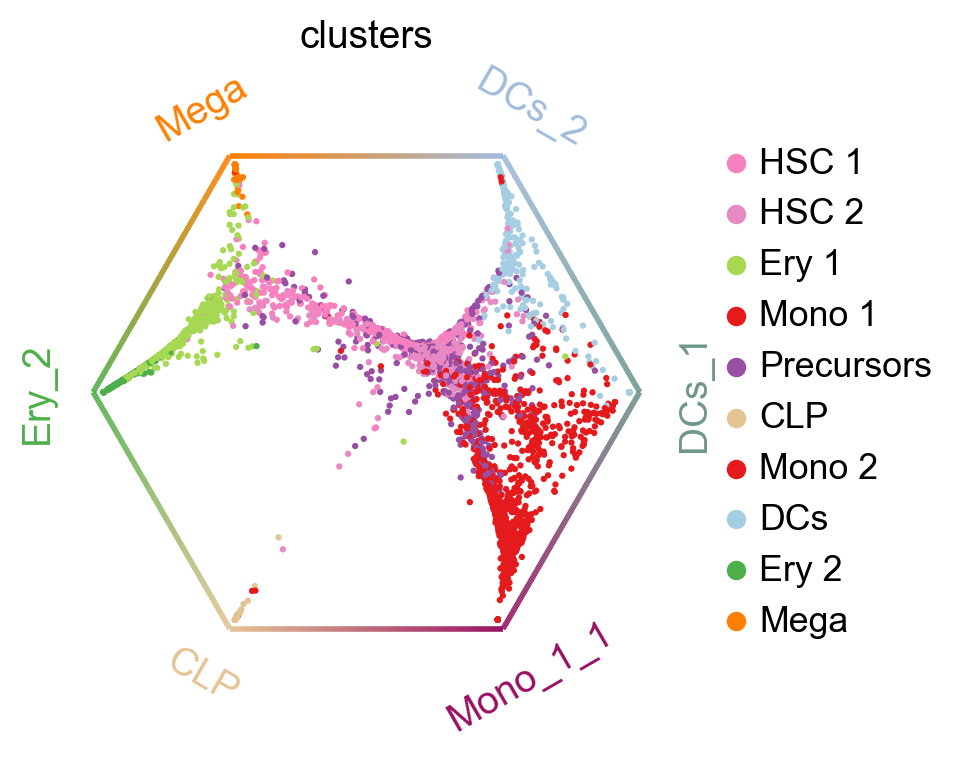

In [26]:
cr.pl.circular_projection(adata, keys="clusters", legend_loc="right")

Each dot represents a cell, colored by cluster labels. Cells are arranged inside the circle according to their fate probabilities; fate biased cells are placed next to their corresponding corner while naive cells are placed in the middle. 

To infer putative driver genes for any of these trajectories, we correlate expression values with fate probabilities. 

In [27]:
mono_drivers = g.compute_lineage_drivers(lineages="Mono_1_1")
mono_drivers.head(10)

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


,Mono_1_1_corr,Mono_1_1_pval,Mono_1_1_qval,Mono_1_1_ci_low,Mono_1_1_ci_high
index,,,,,
AZU1,0.774243,0.0,0.0,0.763706,0.784367
MPO,0.741949,0.0,0.0,0.730135,0.753321
ELANE,0.736333,0.0,0.0,0.724302,0.747916
CTSG,0.722017,0.0,0.0,0.709442,0.734133
PRTN3,0.721471,0.0,0.0,0.708875,0.733606
CFD,0.614439,0.0,0.0,0.598133,0.630237
RNASE2,0.595055,0.0,0.0,0.578143,0.611456
MS4A3,0.581471,0.0,0.0,0.564147,0.598283
SRGN,0.570483,0.0,0.0,0.552833,0.587622


### Visualize expression trends

Given fate probabilities and a pseudotime, we can plot trajectory-specific gene expression trends. Specifically, we fit [Generalized Additive Models](https://en.wikipedia.org/wiki/Generalized_additive_model) (GAMs), weighthing each cells contribution to each trajectory according to its vector of fate probabilities. We start by initializing a `model <cellrank.models>`. 

In [30]:
model = cr.models.GAM(adata)

With the model initialized, we can visualize gene dynamics along specific trajectories. 

Computing trends using `1` core(s)


100%|██████████| 4/4 [00:01<00:00,  2.01gene/s]

    Finish (0:00:02)
Plotting trends


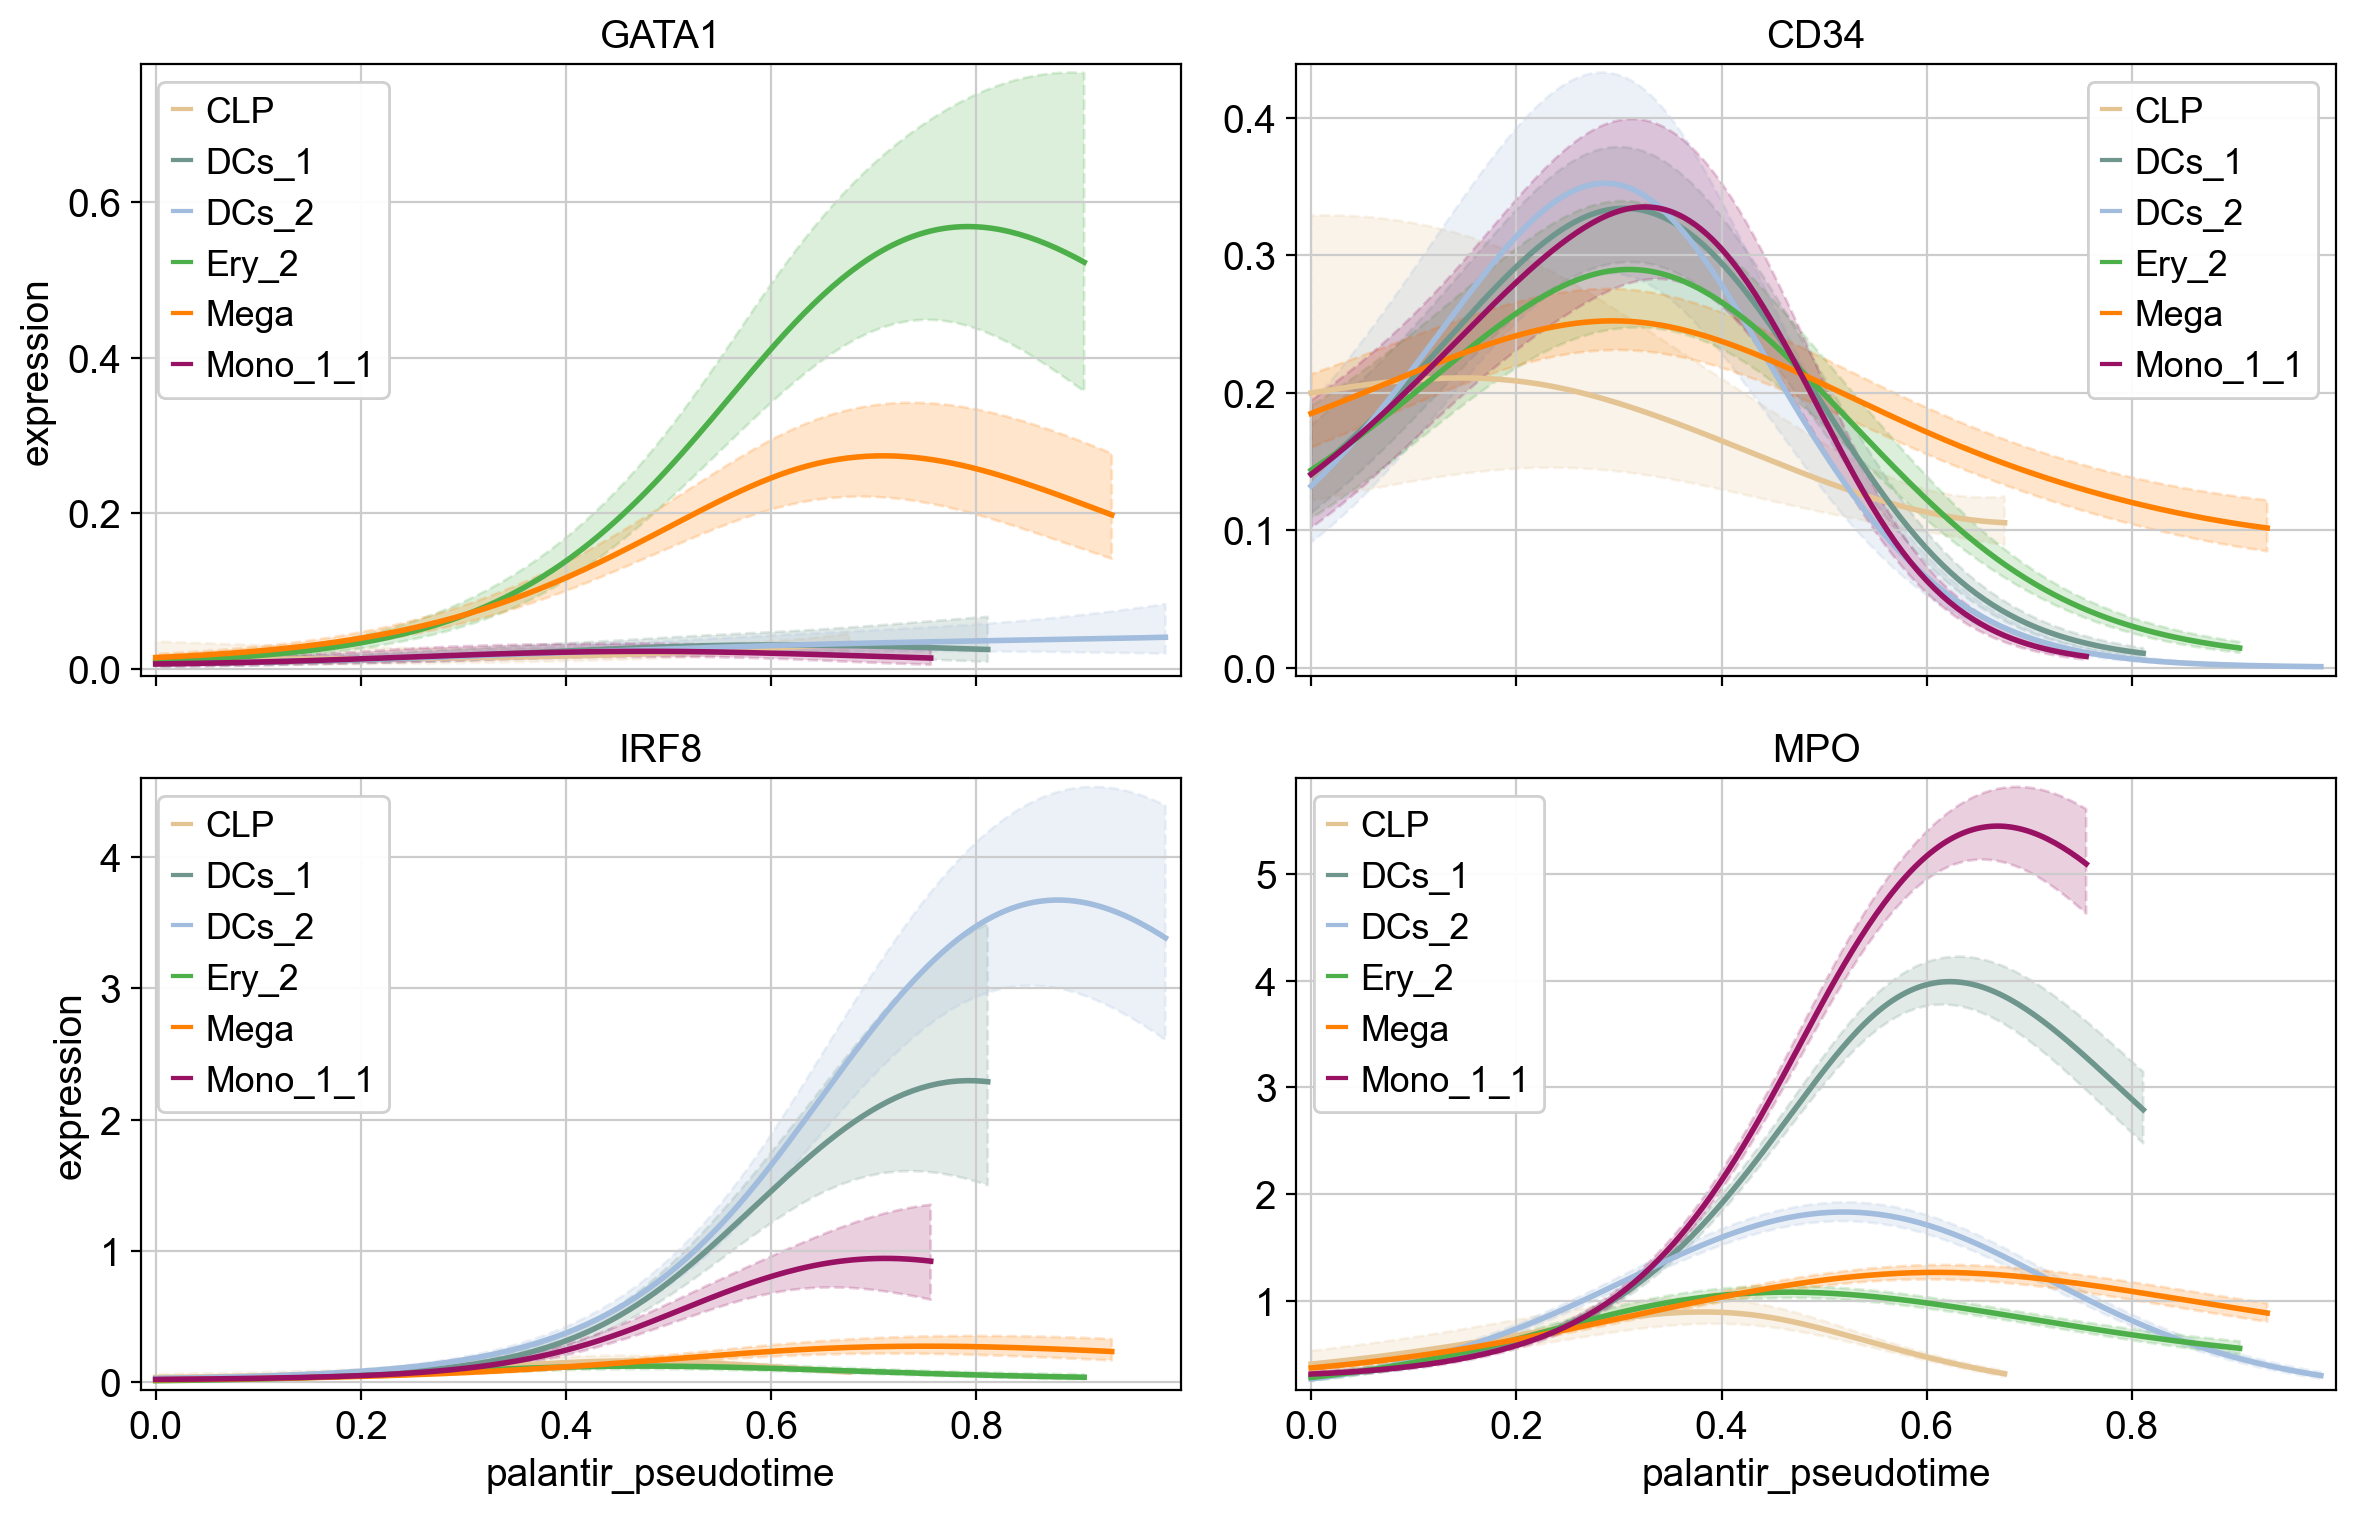

In [32]:
cr.pl.gene_trends(
    adata,
    model=model,
    # data_key="MAGIC_imputed_data",
    genes=["GATA1", "CD34", "IRF8", "MPO"],
    same_plot=True,
    ncols=2,
    time_key="palantir_pseudotime",
    hide_cells=True,
)

Above, we grouped expression trends by gene, and visualized several trajectories per panel. We can also do it the other way round - group expression trends by trajectory, visualize several genes per panel. While this is possible using the line plots from above (set `transpose=True`), we'll demonstrate it using heatmaps. 

Computing trends using `1` core(s)


100%|██████████| 4/4 [00:00<00:00,  4.44gene/s]

    Finish (0:00:00)


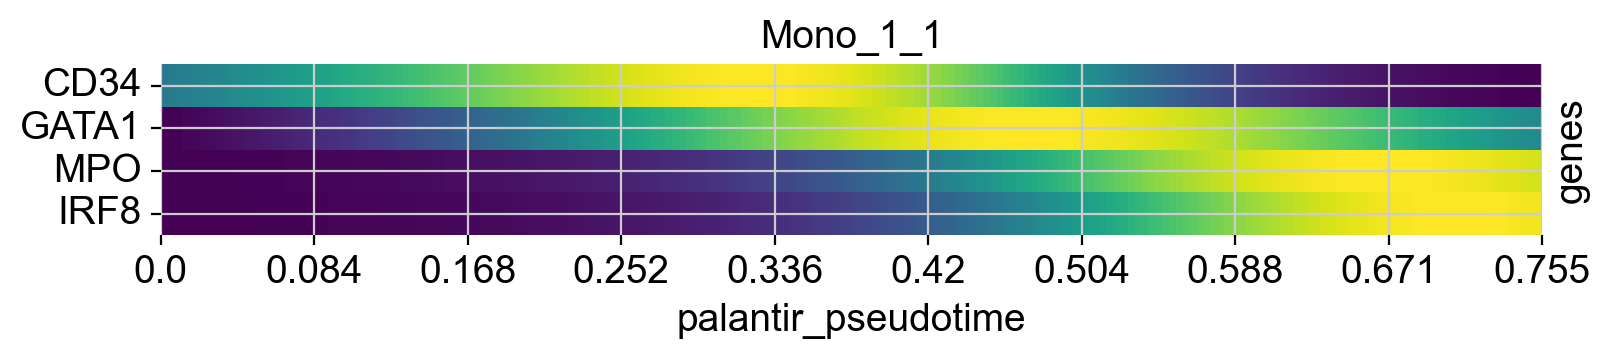

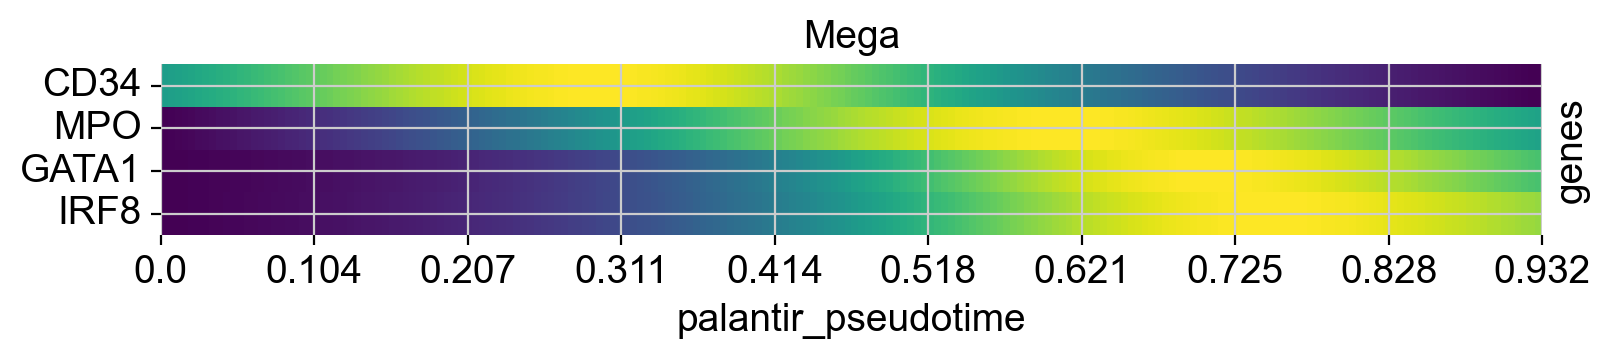

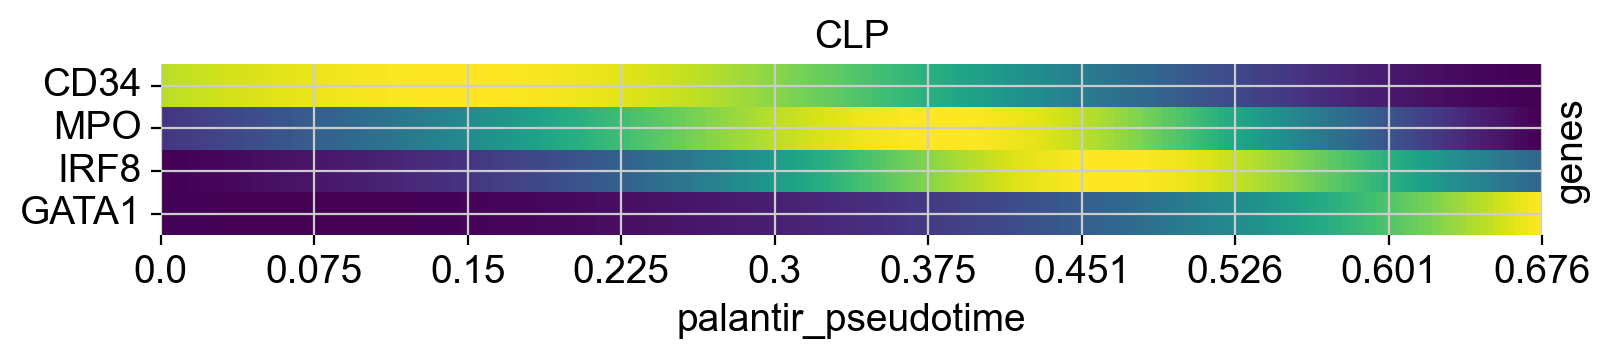

In [33]:
cr.pl.heatmap(
    adata,
    model=model,
    # data_key="MAGIC_imputed_data",
    genes=["GATA1", "CD34", "IRF8", "MPO"],
    lineages=["Mono_1_1", "Mega", "CLP"],
    time_key="palantir_pseudotime",
    cbar=False,
    show_all_genes=True,
)

## Closing matters

### Creating a new kernel - contributing to CellRank

If you have you own method in mind for computing a cell-cell transition matrix, potentially based on some new data modality, consider including it as a kernel in CellRank. That way, you benefit from CellRank's established interfaces with packages like {mod}`~scanpy` or {class}`~anndata.AnnData`, can take advantage of existing downstream analysis capabilities, and immediately reach a large audience of existing CellRank users. 

### Package versions

In [34]:
cr.logging.print_versions()

cellrank==2.0.6 scanpy==1.11.1 anndata==0.11.4 numpy==1.26.4 numba==0.61.0 scipy==1.11.4 pandas==2.2.3 pygpcca==1.0.4 scikit-learn==1.5.2 statsmodels==0.14.4 python-igraph==0.11.8 scvelo==0.3.3 pygam==0.9.1 matplotlib==3.10.1 seaborn==0.13.2
